# Region Generation

This notebok will separate the data into all the updates for a particular project.

Take the tile_placements data and separate it out into frames. A frame is a subset of the data.
The data can be split up into frames based on time (e.g. 1 frame is 30 minutes of data) or by number of updates (e.g. 1 frame is 1 million updates). Every update can only belong to one frame.
After creating the frames, create a graph where every pixel is a node. A single pixel will be a vector of all the different updates that happened within that one frame.

We want to do a min-cut on the graph so that every graph partition represents one image. To select the edge weights, we want edges between pixels within the same image to have a large weight and edges between pixels of different images should have small weights. 

After we do graph partitions within one frame, we want to connect the frames together. 


The ultimate goal is to connect the frames that hold all the updates for a single project and to train a CNN on this data

## Progress Updates:
##### May 15, 2019  

To start out, we will try to split based on updates because there is a large surge of updates near the end, so if we split by time, then the frames near the end will have significantly more updates than frames in the beginning.
There are 16 million datapoints, so we will split 100,000 updates per frame, which will result in 160 frames.
Frames will be stored as CSV files into the folder ../data/frames

##### May 17, 2019

Heirustics: Same color and same user should have a weight of 0. 

In [145]:
import csv
import numpy as np
import scipy
import networkx as nx
import math
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

sys.path.append("../Python_code") # go to parent dir
from canvas_vis import * 
from analytics_combined import *

In [2]:
def pixels_per_project(input_file_proj):
	'''
		Given input file with project assignments (ts,user,x_coordinate,y_coordinate,color,pic_id,pixel,pixel_color)
		computes the number of pixels per project. Some projects might be removed from the analysis.
	'''
	pixels_per_proj = {}

	with open(input_file_proj,'r') as file:
        # Skip first line (header row)
		next(file, None)
		reader = csv.reader(file)

		for r in reader:
			#ts,user,x_coordinate,y_coordinate,color,pic_id,pixel,pixel_color
			proj = r[5]
			pixel = int(r[6])

			if pixel == 1:
				if proj in pixels_per_proj:
					pixels_per_proj[proj] = pixels_per_proj[proj] + 1
				else:
					pixels_per_proj[proj] = 1

	return pixels_per_proj

In [3]:
import copy
import sys
import networkx as nx
import csv
import math

def remove_project_overlap(input_filename,output_filename):
    '''
        Removes the project overlap.
        It keeps the smallest project intact and remove the updates from the larger project.
    '''
    pixel_per_proj = pixels_per_project(input_filename)
    
    with open(input_filename,'r') as file_in:
        with open(output_filename, 'w') as file_out:
            writer = csv.writer(file_out, delimiter = ",")
            writer.writerow(["ts", "user" ,"x_coordinate" ,"y_coordinate" ,"color", "pic_id", "pixel", "pixel_color"])

            # Skip first line (header row)
            next(file_in, None)

            reader = csv.reader(file_in)
            prev=[]
            for r in reader:
                time = int(r[0])
                user = r[1]
                x = int(r[2])
                y = int(r[3])
                color = int(r[4])
                project_id = r[5]
                pixel = int(r[6])
                pixel_color = int(r[7])
                current_list= [time, user, x, y, color, project_id, pixel, pixel_color]
                if prev == []:
                    prev=[time, user, x, y, color, project_id, pixel, pixel_color]
                else:
                    if (current_list[0]==prev[0] and current_list[1]==prev[1]):
                        if(pixel_per_proj[prev[5]] > pixel_per_proj[current_list[5]]):
                            prev=current_list
                    else:
                        writer.writerow(prev)
                        prev=current_list
                        
def remove_project_overlap(input_filename,output_filename):
    '''
        Creates two dictionary indicating the previous update and next update
    '''
    pixel_per_proj = pixels_per_project(input_filename)
    
    with open(input_filename,'r') as file_in:
        with open(output_filename, 'w') as file_out:
            writer = csv.writer(file_out, delimiter = ",")
            writer.writerow(["ts", "user" ,"x_coordinate" ,"y_coordinate" ,"color", "pic_id", "pixel", "pixel_color"])

            # Skip first line (header row)
            next(file_in, None)

            reader = csv.reader(file_in)
            prev=[]
            for r in reader:
                time = int(r[0])
                user = r[1]
                x = int(r[2])
                y = int(r[3])
                color = int(r[4])
                project_id = r[5]
                pixel = int(r[6])
                pixel_color = int(r[7])
                current_list= [time, user, x, y, color, project_id, pixel, pixel_color]
                if prev == []:
                    prev=[time, user, x, y, color, project_id, pixel, pixel_color]
                else:
                    if (current_list[0]==prev[0] and current_list[1]==prev[1]):
                        if(pixel_per_proj[prev[5]] > pixel_per_proj[current_list[5]]):
                            prev=current_list
                    else:
                        writer.writerow(prev)
                        prev=current_list

In [4]:
import copy
import sys
import networkx as nx
import csv
import math

def create_frames_by_time(input_file_name, time_window=sys.maxsize):
    '''
        Creates frames based on a given time window size (time_window) in seconds.
        Returns list of timestamps corresponding to beginning of new frame.
        If no time_window is given, returns everything.
    '''
    max_time=0
    min_time=sys.maxsize
    
    with open(input_file_name,'r') as file:
        # Skip first line (header row)
        next(file, None)
        reader = csv.reader(file)

        for r in reader:
            ts = int(r[0])
            
            if ts < min_time:
                min_time = ts
                
            if ts > max_time:
                max_time = ts
                
    n_frames = math.ceil((max_time-min_time) / (1000 * time_window))
    frames = []
    
    t = min_time
    for i in range(n_frames):
        frames.append(t)
        t = t + 1000 * time_window
    
    frames.append(t+1)
    
    return frames

def create_frames_by_updates(input_file_name, num_updates=sys.maxsize):
    '''
        Creates frames based on a given number of updates per frame.
        Returns list of timestamps corresponding to beginning of new frame.
        If no num_updates is given, returns everything.
    '''
    count = 0
    frames = [0]
    
    with open(input_file_name,'r') as file:
        # Skip first line (header row)
        next(file, None)
        reader = csv.reader(file)

        for r in reader:
            ts = int(r[0])
            proj_smallest = int(r[8])
            if proj_smallest:
                count = count + 1

                if count == num_updates:
                    count = 0
                    frames.append(ts)
    
    if count > 0:
        frames.append(ts)
        
    frames[-1] = frames[-1] + 1
    
    return frames

def create_graph(input_file_name, min_time=0, max_time=sys.maxsize, space_threshold=1, time_threshold=sys.maxsize,
                min_x=0, max_x=1002, min_y=0, max_y=1002):
    '''
        Creates networkx graph of updates within a given frame (or time window) and associated 
        list of update info (timestamp, user, color etc.).
        The input file contains the sorted list of updates with project assignments.
        The values of min_time and max_time define the frame time window.
        Updates are connected spatially based on the space threshold and temporally based
        on the time threshold (in seconds).
        min_x,max_x,min_y,max_y define the area of the canvas for which updates will be considered.
        It returns a networx graph for which node IDs are indexes for the list of updates.
    '''
    updates = []
    
    xy_index = []
    for i in range(1001):
        xy_index.append([])
        for j in range(1001):
            xy_index[i].append([])
    
    i = 0
    with open(input_file_name,'r') as file:
        # Skip first line (header row)
        next(file, None)
        reader = csv.reader(file)

        for r in reader:
            ts = int(r[0])
            x = int(r[2])
            y = int(r[3])
            proj_smallest = int(r[8])
            if proj_smallest:

                if ts >= min_time and ts < max_time and x >= min_x and x < max_x and y >= min_y and y < max_y:
                    user = r[1]
                    color = int(r[4])
                    proj = r[5]
                    pixel = int(r[6])
                    pixel_color = int(r[7])

                    #Collecting update info
                    updates.append([ts, user, x, y, color, proj, pixel, pixel_color])

                    #Spatial index for updates. This is used to find updates near each other.
                    xy_index[x][y].append(i)
                    i = i + 1
    
    G = nx.Graph()
    
    for i in range(len(updates)):
        G.add_node(i)
                
    for xi in range(1001):
        for yi in range(1001):
            for xj in range(xi-space_threshold, xi+space_threshold+1):
                for yj in range(yi-space_threshold, yi+space_threshold+1):
                    if xj >= 0 and yj >= 0 and xj < 1001 and yj < 1001:
                        #Each update is connected at least to the previous update
                        #of the same pixel.
                        if xi == xj and yi == yj:
                            for i in range(0, len(xy_index[xi][yi])-1):
                                if updates[xy_index[xi][yi][i]][0] >= min_time and updates[xy_index[xi][yi][i]][0] < max_time:
                                    if updates[xy_index[xi][yi][i+1]][0] >= min_time and updates[xy_index[xi][yi][i+1]][0] < max_time:
                                        if xy_index[xi][yi][i] != xy_index[xi][yi][i+1]:
                                            G.add_edge(xy_index[xi][yi][i], xy_index[xi][yi][i+1])
                        
                        #Connecting nodes based on spatial and temporal proximity
                        if len(xy_index[xi][yi]) > 0 and len(xy_index[xj][yj]) > 0:
                            i = 0
                            j = 0

                            while i < len(xy_index[xi][yi]) and j < len(xy_index[xj][yj]):
                                ui = updates[xy_index[xi][yi][i]]
                                uj = updates[xy_index[xj][yj][j]]

                                if ui[0] >= min_time and ui[0] < max_time:
                                    if uj[0] >= min_time and uj[0] < max_time:
                                        if ui[0]-uj[0] < 1000 * time_threshold and ui[0]-uj[0] >= 0:
                                            if xy_index[xi][yi][i] != xy_index[xj][yj][j]:
                                                G.add_edge(xy_index[xi][yi][i], xy_index[xj][yj][j])
                                
                                if ui[0] < uj[0]:
                                    i = i + 1
                                else:
                                    j = j + 1

                            if j == len(xy_index[xj][yj]):
                                while i < len(xy_index[xi][yi]):
                                    ui = updates[xy_index[xi][yi][i]]
                                    uj = updates[xy_index[xj][yj][j-1]]
                                    
                                    if ui[0] >= min_time and ui[0] < max_time:
                                        if uj[0] >= min_time and uj[0] < max_time:
                                            if ui[0]-uj[0] < 1000 * time_threshold and ui[0]-uj[0] >= 0:
                                                if xy_index[xi][yi][i] != xy_index[xj][yj][j-1]:
                                                    G.add_edge(xy_index[xi][yi][i], xy_index[xj][yj][j-1])
                                    i = i + 1
                                    
                            elif i == len(xy_index[xi][yi]):
                                while j < len(xy_index[xj][yj]):
                                    ui = updates[xy_index[xi][yi][i-1]]
                                    uj = updates[xy_index[xj][yj][j]]
                                    if ui[0] >= min_time and ui[0] < max_time:
                                        if uj[0] >= min_time and uj[0] < max_time:
                                            if ui[0]-uj[0] < 1000 * time_threshold and ui[0]-uj[0] >= 0:
                                                if xy_index[xi][yi][i] != xy_index[xj][yj][j]:
                                                    G.add_edge(xy_index[xi][yi][i], xy_index[xj][yj][j])
                                    j = j + 1
                                    
    return G, updates     

def get_edge_labels(G, updates, projects_to_remove={}, match_pixel_color=False):
    '''
        Labels edges in the graph based on whether they are inside (True) or
        outside (False) a project. Some edges might be removed if their 
        project in the list of projects to be removed.
        Returns a dictionary with edge labels indexed by edges.
    '''
    edge_labels = {}
    
    for e in G.edges():
        u = e[0]
        v = e[1]
        
        proj_u = ups[u][5]
        proj_v = ups[v][5]
        pixel_u = ups[u][6]
        pixel_v = ups[v][6]
        pixel_color_u = ups[u][7]
        pixel_color_v = ups[v][7]
        
        if proj_u not in projects_to_remove and proj_v not in projects_to_remove:
            if match_pixel_color is True:
                if proj_u == proj_v and pixel_color_u == 1 and pixel_color_v == 1:
                    G[u][v]['label'] = True
                else:
                    G[u][v]['label'] = False
            else:
                if proj_u == proj_v and pixel_u == 1 and pixel_v == 1:
                    G[u][v]['label'] = True
                else:
                    G[u][v]['label'] = False

In [11]:
input_file= "../data/sorted_tile_placements_proj_final.csv"
# output_file= "../data/sorted_tile_placements_proj_nonoverlap.csv"
# remove_project_overlap(input_file,output_file)

In [12]:
'''
    Determine the size of the canvas that is being looked at
'''
min_x = 0
max_x = 100
min_y = 0
max_y = 100


In [13]:
#G, ups = create_graph("../data/sorted_tile_placements_proj.csv", frames[-2], frames[-1], 2)

#Building graph for whole experiment within box (0-100,0-100) of the canvas 
# G, ups = create_graph("../data/sorted_tile_placements_proj_nonoverlap.csv", frames[0], frames[1]+1, 2, 30*60, 0, 100, 0, 100)
G, ups = create_graph(input_file, 0, sys.maxsize, 2, 30*60, min_x, max_x, min_y, max_y)

In [3]:
#frames = create_frames_by_time("../data/sorted_tile_placements_proj.csv", 60 * 60)
# frames = create_frames_by_time(input_file)

In [54]:
#frames = create_frames_by_updates("../data/sorted_tile_placements_proj_nonoverlap.csv", 200000)
# frames = create_frames_by_updates("../data/sorted_tile_placements_proj_nonoverlap.csv")

In [14]:
get_edge_labels(G, ups, {}, True)

In [15]:
G.number_of_nodes()

9825

In [9]:
1001 * 1001 * 16 * 16

256512256

In [8]:
scipy.sparse.csr_matrix.count_nonzero(user_conf) 

NameError: name 'user_conf' is not defined

In [9]:
t = 0

for e in G.edges():
    if G[e[0]][e[1]]['label'] is True:
        t = t + 1
print("true edges = , ", t)
print("false edges = , ", G.number_of_edges()-t)

true edges = ,  364080
false edges = ,  1753497


In [16]:
def compute_color_conflicts(input_file_name, min_time=0, max_time=sys.maxsize, min_x=0, max_x=1002, min_y=0, max_y=1002):
    '''
        Computes for each (x,y) position of the canvas a pairwise value for color conflict
        which is how often at color replaces another at that position.
        
        Parameters are the updates file and the time range of the frame.
        See: create_frames_by_time and create_frames_by_updates.
        
        Returns a sparse array 1001x1001x16x16 (x,y,color,color)
    '''
    xy_color = -np.ones((1001,1001),dtype=np.int8)            
    xy_distance = np.zeros((1001,1001, 16, 16), dtype=np.uint16)
    
    with open(input_file_name,'r') as file:
        # Skip first line (header row)
        next(file, None)
        reader = csv.reader(file)

        for r in reader:
            ts = int(r[0])
            x = int(r[2])
            y = int(r[3])
            proj_smallest = int(r[8])
            if proj_smallest and x >= min_x and x < max_x and y >= min_y and y < max_y:
                
                color_now = int(r[4])
                color_earlier = xy_color[x][y]

                if ts >= min_time and ts < max_time: 
                    if color_earlier >= 0 and color_earlier != color_now:
                        xy_distance[x][y][color_earlier][color_now] = xy_distance[x][y][color_earlier][color_now] + 1

                xy_color[x][y] = color_now
    
    #Creating sparse data structure for memory savings
    sparse_xy_distance = []
    
    for x in range(xy_distance.shape[0]):
        sparse_xy_distance.append([])
        for y in range(xy_distance.shape[1]):
            sparse_xy_distance[x].append(scipy.sparse.csr_matrix(xy_distance[x][y], dtype=np.uint16))
                
    return sparse_xy_distance

# color_conf = compute_color_conflicts("../data/sorted_tile_placements_proj.csv", frames[-2], frames[-1])
color_conf = compute_color_conflicts(input_file, 0, sys.maxsize, min_x, max_x, min_y, max_y)

In [17]:
def compute_user_conflicts(input_file_name, min_time=0, max_time=sys.maxsize, min_x=0, max_x=1002, min_y=0, max_y=1002):
    '''
        Computes for each pair of users a value for color conflict
        which is how often one user re-writes the pixel of another.
        
        Parameters are the updates file and the time range of the frame.
        See: create_frames_by_time and create_frames_by_updates.
        
        Returns a userxuser sparse array with conflicts and also another
        dictionary mapping user ids (strings) to integers.
    '''
    max_uint32 = 4294967295    #Using this for undefined
    xy_user = max_uint32 * np.ones((1001,1001),dtype=np.uint32)
    xy_color = -np.ones((1001,1001),dtype=np.int8)
    user_dist = {}
    user_index = {}
    
    with open(input_file_name,'r') as file:
        # Skip first line (header row)
        next(file, None)
        reader = csv.reader(file)

        for r in reader:
            x = int(r[2])
            y = int(r[3])
            proj_smallest = int(r[8])
            
            if proj_smallest and x >= min_x and x < max_x and y >= min_y and y < max_y:
                ts = int(r[0])
                user_now = r[1]
   
                color_now = int(r[4])
                color_earlier = xy_color[x][y]


                if user_now not in user_index:
                    user_index[user_now] = len(user_index)

                user_now_id = user_index[user_now]
                user_earlier_id = xy_user[x][y]

                if ts >= min_time and ts < max_time: 
                    if user_earlier_id < max_uint32 :
                        if user_earlier_id not in user_dist:
                            user_dist[user_earlier_id] = {}

                    if color_earlier >= 0 and color_earlier != color_now:
                        if user_earlier_id < max_uint32 and user_earlier_id != user_now_id:                        
                            if user_now_id not in user_dist[user_earlier_id]:
                                user_dist[user_earlier_id][user_now_id] = 1
                            else:
                                user_dist[user_earlier_id][user_now_id] + user_dist[user_earlier_id][user_now_id] + 1

                xy_color[x][y] = color_now
                xy_user[x][y] = user_now_id

    #Creating sparse data structure for memory savings
    rows = []
    cols = []
    vals = []
    for ui in user_dist:
        for uj in user_dist[ui]:
            rows.append(ui)
            cols.append(uj)
            vals.append(user_dist[ui][uj])
    
    return scipy.sparse.csr_matrix((vals, (rows, cols)), shape=(len(user_index), len(user_index)), dtype=np.uint16), user_index
    
# user_conf, user_index = compute_user_conflicts("../data/sorted_tile_placements_proj.csv", frames[-2], frames[-1])
user_conf, user_index = compute_user_conflicts(input_file, 0, sys.maxsize, min_x, max_x, min_y, max_y)

In [18]:
def compute_weight(upi, upj, color_conf, user_conf, user_index, ALPHA, EPSILON):
    '''
        Computes weight of edge (upi,upj) based on color and user conflicts (color_conf, user_conf).
        
        ALPHA ([0,1]) is the weight of the color conflict, 1-ALPHA is the weight of the user conflict.
        EPSILON is a small weight to distinguish same color/user from non-conflict.
    '''
    xi = upi[2]
    yi = upi[3]
    xj = upj[2]
    yj = upj[3]
    color_i = upi[4]
    color_j = upj[4]
    user_i = upi[1]
    user_j = upj[1]
    
    if color_i != color_j:
        color_weight = EPSILON
    else:
        color_weight = 0.
    
    #Normalization is commented for now.
    #if color_conf[xi][yi].sum() > 0:
    #    color_weight = color_weight + (color_conf[xi][yi][color_i,color_j] + color_conf[xi][yi][color_j,color_i]) / color_conf[xi][yi].sum()

    color_weight = color_weight + (color_conf[xi][yi][color_i,color_j] + color_conf[xi][yi][color_j,color_i])
    
    #if color_conf[xj][yj].sum() > 0:
    #    color_weight = color_weight + (color_conf[xj][yj][color_j,color_i] + color_conf[xj][yj][color_i,color_j]) / color_conf[xj][yj].sum()
    
    color_weight = color_weight + (color_conf[xj][yj][color_j,color_i] + color_conf[xj][yj][color_i,color_j]) 
    
    user_i_id = user_index[user_i]
    user_j_id = user_index[user_j]
    
    if user_i != user_j:
        user_weight = EPSILON
    else:
        user_weight = 0.
        
    #if user_conf[user_i_id].sum() > 0:
    #    user_weight = user_weight + user_conf[user_i_id,user_j_id] / user_conf[user_i_id].sum()
    
    user_weight = user_weight + user_conf[user_i_id,user_j_id] 
    
    #if user_conf[user_j_id].sum() > 0:
    #    user_weight = user_weight + user_conf[user_j_id,user_i_id] / user_conf[user_j_id].sum()
        
    user_weight = user_weight + user_conf[user_j_id,user_i_id] 
            
    return ALPHA * color_weight + (1.-ALPHA) * user_weight



In [19]:
def create_components(G):
    '''
        Creates one component per node in the graph.
        
        Returns a dictionary mapping nodes to components
        and also the internal weights (0) and sizes (1) of
        the components.
    '''
    comp_assign = {}
    internal_weights = []
    sizes = []
    regions = []
    
    for v in G.nodes():
        comp_assign[v] = len(comp_assign)
        internal_weights.append(0.)
        sizes.append(1)
        regions.append([v])
        
    return comp_assign, internal_weights, sizes, regions

def compute_m_int(int_weights, sizes, comp_u, comp_v, KAPPA):
    ''' 
        Computing internal weights for a pair of components.
        
        KAPPA is a small value that helps with small components.
    '''
    tau_1 = KAPPA / sizes[comp_u]
    tau_2 = KAPPA / sizes[comp_v]
    
    return min(int_weights[comp_u]+tau_1, int_weights[comp_v]+tau_2)

def merge(G, comp_assign, int_weights, sizes, regions, comp_u, comp_v, w):
    '''
        Merges two components (comp_u and comp_v) and updates
        their respective internal weights.
        
        Returns the updated component assignments, internal weights
        and component sizes.
    '''
    if sizes[comp_u] > sizes[comp_v]:
        new_comp = comp_u
        old_comp = comp_v
    else:
        new_comp = comp_v
        old_comp = comp_u
        
    for v in regions[old_comp]:
        comp_assign[v] = new_comp
    
    regions[new_comp].extend(regions[old_comp])
    regions[old_comp] = []
            
    sizes[new_comp] = sizes[comp_u] + sizes[comp_v]
    sizes[old_comp] = 0
        
    int_weights[new_comp] = w
    
    return comp_assign, int_weights, sizes, regions

def region_segmentation(G, KAPPA):
    '''
        Implements region segmentation algorithms by Felzenszwalb and Huttenlocher.
        
        Paper: http://people.cs.uchicago.edu/~pff/papers/seg-ijcv.pdf
        
        Returns dictionary mapping node to region.
    '''
    comp_assign, int_weights, sizes, regions = create_components(G)
    
    i = 0
    for u, v, data in sorted(G.edges(data=True), key=lambda x: x[2]['weight']):
        w=data['weight']
        
        comp_u = comp_assign[u]
        comp_v = comp_assign[v]
        
        if comp_u != comp_v:
            m_int = compute_m_int(int_weights, sizes, comp_u, comp_v, KAPPA)
            
            if w < m_int:
                comp_assign, int_weights, sizes, regions = merge(G, comp_assign, int_weights, sizes, regions,
                        comp_u, comp_v, w)
        
        if i % 10000 == 0:
            print(100*i/G.number_of_edges(), "%")
        
        i = i + 1
        
    return comp_assign

def extract_regions(comp_assign):
    '''
        Extracts actual regions (lists of updates) from region assignements.
        Also returns the region sizes.
    '''
    regions = []
    sizes = []
    region_ids = {}
    
    for c in comp_assign:
        if comp_assign[c] not in region_ids:
            region_ids[comp_assign[c]] = len(region_ids)
            regions.append([])
            sizes.append(0)
            
    for c in comp_assign:
        ID = region_ids[comp_assign[c]]
        regions[ID].append(c)
        sizes[ID] = sizes[ID] + 1
    
    return regions, sizes

In [34]:
def extract_region(updates, region):
    data_color_code = np.uint8(np.zeros((1001,1001)))
    
    for pixel in region:
        u = updates[int(pixel)]
        x = u[2]
        y = u[3]
        color = u[4]
        
        data_color_code[y][x] = color
        
    return data_color_code

def draw_canvas_region(updates, region, out_file):
    canvas_ups = extract_region(updates, region)
    canvas_ups_rgb = canvas_color_code_rgb(canvas_ups)
    draw_canvas(canvas_ups_rgb, out_file)

In [118]:
def create_ground_truth(input_filename, min_time=0, max_time=sys.maxsize, min_x=0, max_x=1002, min_y=0, max_y=1002):
    '''
        Given the input file, create and return a dictionary of the ground truth for the
        pixel assignments.
        
        Each pixel's ID will be based upon the index it is found within the file
    '''
    line_number = 0
    ground_truth = dict()
    with open(input_filename,'r') as file_in:
    
        # Skip first line (header row)
        next(file_in, None)

        reader = csv.reader(file_in)
        for r in reader:
            ts = int(r[0])
            user = r[1]
            x = int(r[2])
            y = int(r[3])
            color = int(r[4])
            pic_id = r[5]
            final_pixel = int(r[6])
            final_pixel_color = int(r[7])
            smallest_proj = int(r[8])
            
            # The ground truth pixel assignments will be based on the pixel assigned to the smallest project
            if smallest_proj and ts >= min_time and ts < max_time and x >= min_x and x < max_x and y >= min_y and y < max_y:
                if pic_id not in ground_truth:
                    ground_truth[pic_id] = [line_number]
                else:
                    ground_truth[pic_id].append(line_number)
                    
                line_number += 1
    
    return ground_truth
                

def get_region_borders(region, updates):
    '''
        Given a region (list of lists), return the min x, min y, max x, and max y
    '''
    min_x = sys.maxsize
    min_y = sys.maxsize
    max_x = 0
    max_y = 0
    for update_id in region:
        
        update = updates[int(update_id)]
        x = int(update[2])
        y = int(update[3])
        
        if x > max_x:
            max_x = x
        if x < min_x:
            min_x = x
        if y > max_y:
            max_y = y
        if y < min_y:
            min_y = y
            
    return min_x, min_y, max_x, max_y

def get_rectangle_overlap_area(min_x1, max_x1, min_y1, max_y1, min_x2, max_x2, min_y2, max_y2):
    '''
        Given the coordinates of the corners of two rectangles, return the area of the overlapping region
    '''
    
    # First, calculate a bounding box around the two rectangles
    bounding_box_area =  (max(max_x1, max_x2) - min(min_x1, min_x2)) * (max(max_y1, max_y2) - min(min_y1, min_y2))  
    
    
    overlap_max_x = min(max_x1, max_x2)
    overlap_max_y = min(max_y1, max_y2)
    overlap_min_x = max(min_x1, min_x2)
    overlap_min_y = max(min_y1, min_y2)
    
    if overlap_max_x > overlap_min_x and overlap_max_y > overlap_min_y:
        return ((overlap_max_x - overlap_min_x) * (overlap_max_y - overlap_min_y))
    else:
        return 0

def get_max_iou(locations, region, updates, ground_truth):
    '''
        Given a region, check and return the maximum the iou with every project in the ground truth.
    '''
    max_iou = 0
    max_pic_id = None
    for pic_id in ground_truth:
        project = locations[pic_id]
        min_x, min_y, max_x, max_y =  get_region_borders(region, updates)
        
        # only check this region with the pic_id if the bounding boxes overlap by at least the threshold
        overlap_area = get_rectangle_overlap_area(min_x, max_x, min_y, max_y, project.get_left(), project.get_right(), project.get_bottom(), project.get_top())
        total_area = (abs(max_x - min_x) * abs(max_y - min_y)) + (abs(project.get_right() - project.get_left()) * abs(project.get_top() - project.get_bottom())) - overlap_area
        
        if total_area > 0:
        
            iou = overlap_area / total_area
            if iou > max_iou:
                max_iou = iou
                max_pic_id = pic_id
            
    return max_iou, max_pic_id
    
    
# Given a set_of_updates and the ground truth data, evaluate the precision and recall
# ground_truth is a dictionary of the following format:
'''
    "image_id" : [ list of update IDS belonging to this image ]
'''

# Each update tuple is assumed to be this format:
# (updateID, time, user, x, y, color, pic_id)
def evaluate(regions, updates, ground_truth, threshold = 0.50, draw = False):
    
#     stub = []
    
    region_assignments = dict()
    num_assignments_made = len(regions)
    ground_truth_size = len(ground_truth)
    locations = store_locations("../data/atlas_complete.json")
    image_assignment = dict()
    num_correct_counter = 0
    
    for region in regions:
        iou, pic_id = get_max_iou(locations, region, updates, ground_truth)
        
        
#         if pic_id == "73":
#             if region_assignments.get(pic_id) is None:
#                 region_assignments[pic_id] = iou
#                 stub = region
#             else:
#                 if region_assignments[pic_id] < iou:
#                     region_assignments[pic_id] = iou
#                     stub = region
                
        if iou > threshold:
            if region_assignments.get(pic_id) is None:
                # If this artwork has not been predicted yet, then add 1 to num_correct_counter and set the iou for
                # this image
                num_correct_counter += 1
                region_assignments[pic_id] = iou
            else:
                # Else if there is a higher iou, update the value within region_assignments
                if iou > region_assignments[pic_id]:
                    region_assignments[pic_id] = iou

                
            if draw:
                name = locations[pic_id].get_name().replace('/', '')
                draw_canvas_region(updates, region, "../plots/" + name + "_region.png")
                draw_canvas_region(updates, ground_truth[pic_id], "../plots/" + name + "_truth.png")

#     runescape = locations["73"].get_name()
#     draw_canvas_region(updates, stub, "../plots/" + runescape + ".png")
#     print("RUNSECAPE IOU:", region_assignments["73"])
    
    precision = num_correct_counter / num_assignments_made
    
    recall = num_correct_counter / ground_truth_size
    
    return num_correct_counter, num_assignments_made, precision, recall, region_assignments

In [90]:
ground_truth = create_ground_truth(input_file,0, sys.maxsize, min_x, max_x, min_y, max_y)

ALPHA ([0,1]) is the weight of the color conflict, 1-ALPHA is the weight of the user conflict.

EPSILON is a small weight to distinguish same color/user from non-conflict.

KAPPA is a small value that helps with small components. (We should keep it low)

In [115]:
alpha = 0.9
epsilon = 0.1 
kappa = 0.1
i = 0
for e in G.edges():
    w = compute_weight(ups[e[0]], ups[e[1]], color_conf, user_conf, user_index, alpha, epsilon)
    G[e[0]][e[1]]['weight'] = w
    if i % 10000 == 0:
        print(100*i/G.number_of_edges(), "%")
    i = i + 1
comp_assign = region_segmentation(G, kappa)
regions, sizes = extract_regions(comp_assign)

0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %


In [103]:
print(len(regions))

2638


In [77]:
# count = 0
# for region in regions:
#     if len(region) > 15:
#         print(len(region))
#         count += 1
# print("Final count:", count)

In [78]:
# for pic_id in ground_truth:
#     print(len(ground_truth[pic_id]))

RUNSECAPE IOU: 0.06487068965517241
Regions: 3975
Total correct assignments: 0
Total assignments made: 3975
Ground truth size: 24
Precision: 0.0
Recall: 0.0
CPU times: user 3.71 s, sys: 38.9 ms, total: 3.75 s
Wall time: 3.69 s


<Figure size 432x288 with 0 Axes>

<Figure size 7200x7200 with 0 Axes>

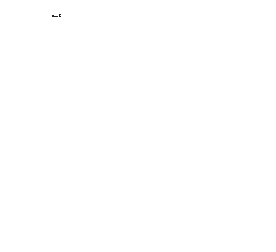

In [117]:
%%time
num_correct_counter, num_assignments_made, precision, recall, region_assignments = evaluate(regions, ups, ground_truth, 1.1, draw = True)
ground_truth_size = len(ground_truth)
print("Regions:", len(regions))
print("Total correct assignments:", num_correct_counter)
print("Total assignments made:", num_assignments_made)
print("Ground truth size:", ground_truth_size)
print("Precision:", precision)
print("Recall:", recall)

In [101]:
'''
    Run the evaluation function for multiple values of ALPHA, EPSILON, KAPPA
    Write the results of the precision and recall to a file
'''
evaluation_filename = "../data/evaluation_tests.csv"
with open(evaluation_filename, 'w') as file_out:
    writer = csv.writer(file_out, delimiter = ",")
    writer.writerow(["ALPHA", "EPSILON", "KAPPA", "#Regions", "total correct assignments", "Precision", "Recall"])
    
    alpha = 0
        
    while alpha <= 1:
        epsilon = 0
        while epsilon <= 1:
            kappa = 0
            while kappa <= 1:
                i = 0
                for e in G.edges():
                    w = compute_weight(ups[e[0]], ups[e[1]], color_conf, user_conf, user_index, alpha, epsilon)
                    G[e[0]][e[1]]['weight'] = w
                    if i % 10000 == 0:
                        print(100*i/G.number_of_edges(), "%")
                    i = i + 1
                comp_assign = region_segmentation(G, kappa)
                regions, sizes = extract_regions(comp_assign)
                num_correct_counter, num_assignments_made, precision, recall, region_assignments = evaluate(regions, ups, ground_truth, 0.50)
                

                writer.writerow([alpha, epsilon, kappa, len(regions), num_correct_counter, precision, recall])
                
                kappa += 0.1
            epsilon += 0.1
        alpha += 0.1
    

0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831

41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058

82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415

0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831

0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831

41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058

82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415

0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831

0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831

41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058

82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415

0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831

0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831

41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058

82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415514529348 %
82.78831029058696 %
0.0 %
41.39415

In [133]:

xdata = []  #ALPHA
ydata = []  #EPSILON
zdata = []  #KAPPA
precision_data = []  #PRECISION
recall_data = []  #RECALL

with open(evaluation_filename, 'r') as file_in:
    # Skip first line (header row)
    next(file_in, None)

    reader = csv.reader(file_in)
    
    for r in reader:
        x = float(r[0])
        y = float(r[1])
        z = float(r[2])
        precision = float(r[5])
        recall = float(r[6])
        
        xdata.append(x)
        ydata.append(y)
        zdata.append(z)
        precision_data.append(precision)
        recall_data.append(recall)
        


In [151]:
%matplotlib tk 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Data for a three-dimensional line
line = np.linspace(0, 1, 1000)
ax.plot3D(line, line, line, 'gray')

# Data for three-dimensional scattered points
img = ax.scatter(xdata, ydata, zdata, c=recall_data, cmap=plt.hot());
ax.set_title("RECALL")
ax.set_xlabel("ALPHA")
ax.set_ylabel("EPSILON")
ax.set_zlabel("KAPPA")
fig.colorbar(img)
plt.savefig("../plots/recall_hotness.png")
plt.show()

In [152]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Data for a three-dimensional line
line = np.linspace(0, 1, 1000)
ax.plot3D(line, line, line, 'gray')

# Data for three-dimensional scattered points
img = ax.scatter(xdata, ydata, zdata, c=precision_data, cmap=plt.hot());
ax.set_title("PRECISION")
ax.set_xlabel("ALPHA")
ax.set_ylabel("EPSILON")
ax.set_zlabel("KAPPA")
fig.colorbar(img)
plt.savefig("../plots/precision_hotness.png")
plt.show()

In [ ]:
true_weights = []
false_weights = []

for e in G.edges():
    if G[e[0]][e[1]]['label'] is True:
        true_weights.append(G[e[0]][e[1]]['weight'])
    else:
        false_weights.append(G[e[0]][e[1]]['weight'])
print("TRUE EDGES, AVG = ", np.average(true_weights), " STD = ", np.std(true_weights))
print("FALSE EDGES, AVG = ", np.average(false_weights), " STD = ", np.std(false_weights))

In [ ]:
'''
    Run the evaluation function for multiple values of ALPHA, EPSILON, KAPPA
    Write the results of the precision and recall to a file
'''
evaluation_filename = "../data/evaluation_alpha_tests.csv"
with open(evaluation_filename, 'w') as file_out:
    writer = csv.writer(file_out, delimiter = ",")
    writer.writerow(["ALPHA, EPSILON, KAPPA, Precision, Recall"])
    
    alpha = 0
    epsilon = .1 
    kappa = 0.055
    
    while alpha <= 1:
        i = 0
        for e in G.edges():
            w = compute_weight(ups[e[0]], ups[e[1]], color_conf, user_conf, user_index, alpha, epsilon)
            G[e[0]][e[1]]['weight'] = w
            if i % 10000 == 0:
                print(100*i/G.number_of_edges(), "%")
            i = i + 1
        comp_assign = region_segmentation(G, kappa)
        regions, sizes = extract_regions(comp_assign)
        num_correct_counter, num_assignments_made, precision, recall = evaluate(regions, ups, ground_truth, 0.50)
                
        writer.writerow([alpha, epsilon, kappa, precision, recall])
        alpha += 0.2
    

0.0 %
0.472237845424275 %
0.94447569084855 %
1.416713536272825 %
1.8889513816971 %
2.361189227121375 %
2.83342707254565 %
3.305664917969925 %
3.7779027633942 %
4.250140608818475 %
4.72237845424275 %
5.194616299667025 %
5.6668541450913 %
6.139091990515575 %
6.61132983593985 %
7.0835676813641255 %
7.5558055267884 %
8.028043372212675 %
8.50028121763695 %
8.972519063061226 %
9.4447569084855 %
9.916994753909774 %
10.38923259933405 %
10.861470444758325 %
11.3337082901826 %
11.805946135606876 %
12.27818398103115 %
12.750421826455426 %
13.2226596718797 %
13.694897517303975 %
14.167135362728251 %
14.639373208152525 %
15.1116110535768 %
15.583848899001076 %
16.05608674442535 %
16.528324589849625 %
17.0005624352739 %
17.472800280698177 %
17.94503812612245 %
18.417275971546726 %
18.889513816971 %
19.361751662395275 %
19.83398950781955 %
20.306227353243827 %
20.7784651986681 %
21.250703044092376 %
21.72294088951665 %
22.195178734940924 %
22.6674165803652 %
23.139654425789477 %
23.61189227121375 %
2

95.39204477570355 %
95.86428262112783 %
96.3365204665521 %
96.80875831197638 %
97.28099615740065 %
97.75323400282493 %
98.2254718482492 %
98.69770969367347 %
99.16994753909775 %
99.64218538452202 %
Total correct assignments: 0
Total assignments made: 229931
Precision: 0.0
Recall: 0.0
0.0 %
0.472237845424275 %
0.94447569084855 %
1.416713536272825 %
1.8889513816971 %
2.361189227121375 %
2.83342707254565 %
3.305664917969925 %
3.7779027633942 %
4.250140608818475 %
4.72237845424275 %
5.194616299667025 %
5.6668541450913 %
6.139091990515575 %
6.61132983593985 %
7.0835676813641255 %
7.5558055267884 %
8.028043372212675 %
8.50028121763695 %
8.972519063061226 %
9.4447569084855 %
9.916994753909774 %
10.38923259933405 %
10.861470444758325 %
11.3337082901826 %
11.805946135606876 %
12.27818398103115 %
12.750421826455426 %
13.2226596718797 %
13.694897517303975 %
14.167135362728251 %
14.639373208152525 %
15.1116110535768 %
15.583848899001076 %
16.05608674442535 %
16.528324589849625 %
17.0005624352739 %

87.83623924891515 %
88.30847709433942 %
88.7807149397637 %
89.25295278518797 %
89.72519063061225 %
90.19742847603652 %
90.6696663214608 %
91.14190416688507 %
91.61414201230936 %
92.08637985773363 %
92.5586177031579 %
93.03085554858218 %
93.50309339400646 %
93.97533123943073 %
94.447569084855 %
94.91980693027928 %
95.39204477570355 %
95.86428262112783 %
96.3365204665521 %
96.80875831197638 %
97.28099615740065 %
97.75323400282493 %
98.2254718482492 %
98.69770969367347 %
99.16994753909775 %
99.64218538452202 %


In [87]:
def updates_region(ups, region):
    ups_region = []
    
    for u in sorted(region):
        ups_region.append(ups[u])
        
    return ups_region

ind  = np.argsort(sizes)

ups_max_region = updates_region(ups, regions[ind[-7]])

In [88]:
len(ups_max_region)

3677

<Figure size 432x288 with 0 Axes>

<Figure size 7200x7200 with 0 Axes>

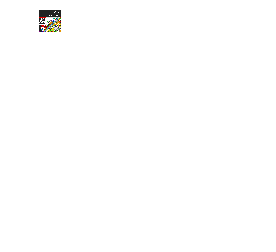

In [119]:
def extract_canvas_updates(updates):
    data_color_code = np.uint8(np.zeros((1001,1001)))
    
    for u in updates:
        x = u[2]
        y = u[3]
        color = u[4]
        
        data_color_code[y][x] = color
        
    return data_color_code

canvas_ups = extract_canvas_updates(ups)
canvas_ups_rgb = canvas_color_code_rgb(canvas_ups)

draw_canvas(canvas_ups_rgb, "../plots/frame.png")

<Figure size 432x288 with 0 Axes>

<Figure size 7200x7200 with 0 Axes>

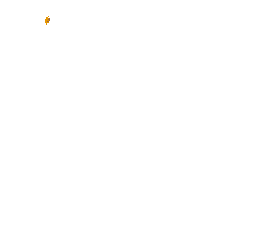

In [89]:
canvas_ups = extract_canvas_updates(ups_max_region)
canvas_ups_rgb = canvas_color_code_rgb(canvas_ups)

draw_canvas(canvas_ups_rgb, "../plots/max_region.svg")

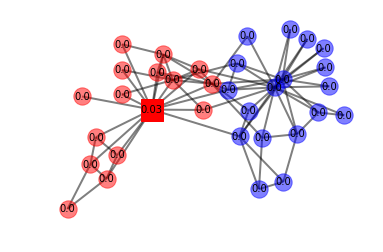

In [110]:
import array
import networkx as nx
import numpy as np
import queue 
import sys
import operator

def create_idx(G):
    '''
        Associates each vertex in G to an integer from 0 ... number-of-vertices minus one.
    '''
    idx = {}
    for v in G.nodes():
        idx[v] = len(idx)
        
    return idx

def push(G, u, p, r, alpha, idx, weight=None):
    '''
        Push operation for approximate pagerank. Updates probability and residual vectors 
        based on a single vertex u.
    '''
    idx_u = idx[u]
    
    p[idx_u] = p[idx_u] + alpha * r[idx_u]
    
    deg_u = G.degree(u, weight=weight)
        
    for v in G.neighbors(u):
        idx_v = idx[v] 
        
        if weight is None:
            w = 1. / deg_u
        else:
            w = G[u][v][weight] / deg_u
        
        r[idx_v] = r[idx_v] + 0.5 * w * (1.-alpha) * r[idx_u]
     
    r[idx_u] = 0.5 * (1.-alpha) * r[idx_u]
    
    return p, r

def approximate_pagerank(G, v, alpha, epsilon, idx, weight=None):
    '''
        Computes approximate personalized pagerank vector for vertex v.
        alpha is the teleportation probability and epsilon is the error.
        
        Uses a queue to keep vertices with residual values higher than 
        allowed.
    '''
    p = np.zeros(G.number_of_nodes())
    r = np.zeros(G.number_of_nodes())
    
    #For quickly checking which vertices are in the queue
    in_queue = array.array('B', [0] * G.number_of_nodes())
  
    Q = queue.Queue(maxsize=G.number_of_nodes()) 
    
    #Initialization
    idx_v = idx[v]
    in_queue[idx_v] = 1
    r[idx_v] = 1.
    Q.put(v)
    
    while Q.empty() is False:
        
        #Retrieving vertex from queue
        u = Q.get()
        idx_u = idx[u]
        deg_u = G.degree(u, weight=weight)
        
        while (r[idx_u] / deg_u) < epsilon and Q.empty() is False:
            in_queue[idx_u] = 0   
            u = Q.get()
            idx_u = idx[u]
            deg_u = G.degree(u, weight=weight)
            
        while (r[idx_u] / deg_u) >= epsilon:
            #Push for vertex u.
            p, r = push(G, u, p, r, alpha, idx, weight)
            
            #Checking whether neighbors of u should be added to queue
            for n in G.neighbors(u):
                idx_n = idx[n]
                deg_n = G.degree(n, weight=weight)
                
                if r[idx_n] / deg_n >= epsilon and in_queue[idx_n] != 1:
                    in_queue[idx_n] = 1
                    Q.put(n)
                                        
        in_queue[idx_u] = 0
                    
    return p

def sweep(G, p, idx, weight):
    '''
        Sweeping algorithm for computing the cut (S,V/S) with minimum conductance based on 
        vertices sorted according to their value in the probability vector p.
    '''
    sweep_vec = {}
    total_vol = 0.
    min_conduct = sys.float_info.max
    best_cut = None
    
    for v in G.nodes():
        #value = p[v] / deg[v]
        sweep_vec[v] = p[idx[v]] / G.degree(v, weight=weight)
        total_vol = total_vol + G.degree(v, weight=weight)
        
    sorted_sweep_vec = sorted(sweep_vec.items(), key=operator.itemgetter(1), reverse=True)
    vol = 0.
    cut = 0.
    
    #For quickly checking vertices in the set S
    in_s = array.array('B', [0] * G.number_of_nodes())
            
    for i in range(len(sorted_sweep_vec)-1):
        v = sorted_sweep_vec[i][0]
        
        #Updating volume of S
        vol = vol + G.degree(v, weight=weight)
        min_vol = min(vol, total_vol-vol)
        
        #Updating total weight of the cut
        for u in G.neighbors(v):
            if weight is None:
                w = 1.
            else:
                w = G[u][v][weight]
                    
            if in_s[idx[u]] == 1:
                cut = cut - w
            else:
                cut = cut + w
                
        in_s[idx[v]] = 1
        
        #conductance
        conduct = cut / min_vol
        
        #print("cut = ", cut, " conductance = ", conduct, " min_vol = ", min_vol, " min_conductance = ", min_conduct)
        
        if conduct <= min_conduct:
            min_conduct = conduct
            best_cut = i
          
    #Creating set S for the optimal cut    
    S = []
    for i in range(best_cut+1):
        S.append(sorted_sweep_vec[i][0])
        
    return S, min_conduct

def pagerank_cut(G, v,  alpha, epsilon, weight):
    '''
        Algorithm for minimum conductance cut (S,V/S) around the neighborhood
        of a particular vertex v. Approximate pagerank vector can be computed
        fast based on local updates. Cut is computed using a sweep procedure
        over pagerank vector.
    '''
    idx = create_idx(G)
    p = approximate_pagerank(G, v, alpha, epsilon, idx, weight)
    S, conduct = sweep(G, p, idx, weight)
    
    probs = {}
    for v in G.nodes():
        probs[v] = p[idx[v]]
    
    return S, probs, conduct

G = nx.karate_club_graph()
v = 0
S, probs, conduct = pagerank_cut(G, v,  .01, 0.01, None)

P1 = []
P2 = []
labels = {}

for u in G.nodes():
    labels[u] = np.around(probs[u], decimals=2)
    if u not in S:
        P2.append(u)
    elif u != v:
        P1.append(u)

pos = nx.fruchterman_reingold_layout(G)

nx.draw_networkx_nodes(G,pos,node_color='red', nodelist=P1,node_size=300, alpha=0.5)
nx.draw_networkx_nodes(G,pos,node_color='blue', nodelist=P2,node_size=300, alpha=0.5)
nx.draw_networkx_nodes(G,pos,node_color='red', nodelist=[v],node_size=500, node_shape='s')
nx.draw_networkx_labels(G,pos=pos,labels=labels,font_size=10)
nx.draw_networkx_edges(G, pos, width=2, edge_color='black', style='solid', alpha=0.5)

limits=plt.axis('off')
plt.savefig("pagerank_cut.png", bbox_inches='tight', pad_inches=0, dpi=1000) 
plt.show() 

In [109]:
probs

{0: 0.11731583868654788,
 1: 0.053792510236789,
 2: 0.055373349029618664,
 3: 0.036509313626549716,
 4: 0.02034488003133287,
 5: 0.026739841807770354,
 6: 0.026752474349439132,
 7: 0.0243974197686955,
 8: 0.027173437755281343,
 9: 0.010213775636167086,
 10: 0.020357512578127575,
 11: 0.0071673130916422856,
 12: 0.013131438629553478,
 13: 0.029193808451711718,
 14: 0.009527845655530668,
 15: 0.009527845655530668,
 16: 0.013088616253128167,
 17: 0.013025872925719348,
 18: 0.009527845655530668,
 19: 0.017822261608735537,
 20: 0.009527845655530668,
 21: 0.013025872925719348,
 22: 0.009527845655530668,
 23: 0.023575487641905781,
 24: 0.01454795375675989,
 25: 0.01442837853566142,
 26: 0.0093692142281897178,
 27: 0.019548837401201127,
 28: 0.01527682625841301,
 29: 0.018701403993761093,
 30: 0.020693568975494007,
 31: 0.031114269788417127,
 32: 0.058046836943592243,
 33: 0.083531653290369406}

In [104]:
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33))

In [7]:
scipy.sparse.csr_matrix(np.random.random((5,5)))

<5x5 sparse matrix of type '<class 'numpy.float64'>'
	with 25 stored elements in Compressed Sparse Row format>